##### Imports

In [ ]:
from scripts.validation import *
from scripts.plotting import * 

Progress tracking

In [2]:
# track progress
tqdm.pandas()

## Realism validation
- now that we have found toxicity-based clusters of comments, we want to validate the simulator:
    - focusing on real and before moderation data
    - in terms of how well it is able to replicate patterns in real data
        - using a multi-dimensional evaluation framework based on the trasparent features derived from the feature extraction pipeline
        - toxicity, personality, emotion/sentiment, linguistics, readability

- we do both global and local validations:
    - global, comparing full datasets against each other
    - local, comparing matching toxic profiles for each dataset

### Datasets

In [3]:
# real
df_real = pd.read_csv("../data_real_before/PANDORA_test.csv", encoding = "utf-8")
# simulated before mod
df_bef = pd.read_csv("../data_real_before/SIMULATOR_exante_bef.csv", encoding = "utf-8")

##### Feature Engineering (this is done before)
- we want to derive features from the already extracted ones, could be more insightful
- especially for linguistic count-based features, to have measures independent of the different absolute lengths

In [4]:
feat_engineering(df_real)
feat_engineering(df_bef)

100%|██████████| 3131/3131 [00:00<00:00, 130311.14it/s]


##### Feature selection
- keep only features shared across all datasets (real and simulated), to be able to do comparative analyses
- we exclude also the textual bodies and other irrelevant features for the analysis, such as parent_id and age (which has many missing values in the real dataset)

In [5]:
# features to keep
feats_shared = [col for col in df_real.columns if (col in df_bef.columns) and (col not in ["llm_body", "parent_id", "age"])]
print(feats_shared)
df_real = df_real[feats_shared].copy()
df_bef = df_bef[feats_shared].copy()

['author', 'comment_id', 'std_body', 'gender', 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism', 'num_punct', 'num_sents', 'num_words_upp', 'num_emoji', 'num_emoji_pos', 'num_emoji_neg', 'emoji_unique', 'emoji_list', 'fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'polarity', 'subjectivity', 'valence', 'arousal', 'dominance', 'flesch', 'flesch_kincaid', 'fog', 'smog', 'ari', 'coleman_liau', 'dale_chall', 'linsear', 'difficult_words', 'num_words', 'num_words_unique', 'num_words_adj', 'num_words_noun', 'num_words_verb', 'num_words_lex', 'num_stopw', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'is_toxic', 'go', 'holy fuck', 'homosexual', 'say', 'know', 'well', 'bunch', 'shit', 'man', 'racist', 'would', 'stupid', 'also', 'guy', 'liberal', 'make', 'country', 'religion', 'real', 'crap', 'right', 'keep', 'people', 'dick', 'need', 'asshole', 'nothing', 'woman', 'bitch', 'on

In [6]:
print(f"Shape real data: {df_real.shape}")
df_real.head(2)

Shape real data: (50000, 144)


,author,comment_id,std_body,gender,openness,conscientiousness,extraversion,agreeableness,neuroticism,num_punct,num_sents,num_words_upp,num_emoji,num_emoji_pos,num_emoji_neg,emoji_unique,emoji_list,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,polarity,subjectivity,valence,arousal,dominance,flesch,flesch_kincaid,fog,smog,ari,coleman_liau,dale_chall,linsear,difficult_words,num_words,num_words_unique,num_words_adj,num_words_noun,num_words_verb,num_words_lex,num_stopw,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,is_toxic,go,holy fuck,homosexual,say,know,well,bunch,shit,man,racist,would,stupid,also,guy,liberal,make,country,religion,real,crap,right,keep,people,dick,need,asshole,nothing,woman,bitch,one,give,fuck shit,die,black,immigrant,kill,dude,fucking,nigga,suck,take,good,try,idiot,call,insult insult,life,think,society,fuckin,someone,want,stop,see,f cking,way,time,damn,white,fuck,government,get,u,gay,even,death,thing,control,money,muslim,family,hope,really,like,is_real,cluster,sent_balance,sent_emoji_balance,punct_ratio,upper_ratio,emoji_ratio,adj_ratio,noun_ratio,verb_ratio,lex_ratio,stopw_ratio,words_sent_ratio,ttr,complex_ratio
0,quiteafewfireflies,306083,oh many flaw haha mostly affect anyone else,f,very high,very low,medium,medium,very high,5,2,0,0,0,0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425,0.45,0.052826,0.041652,0.050913,87.72,3.3,3.60,0.0,1.9,2.52,6.71,4.0,2.0,18,17,2,4,3,9,10,0.004256,0.000098,0.000337,0.000113,0.0,0.000168,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.0,0,0.277778,0.0,0.0,0.111111,0.222222,0.166667,0.5,0.555556,9.0,1.000000,0.111111
1,Djzongreethesecond,134780,go vote rand paul guess not probably trump guess,t,medium,very low,medium,very low,very high,1,1,0,0,0,0,,,0.0,0.1,0.0,0.1,0.3,0.1,0.1,0.1,0.0,0.1,0.000,0.00,0.120190,0.085048,0.094619,86.03,6.0,9.71,0.0,4.7,2.85,7.90,10.5,1.0,20,16,1,8,3,12,11,0.000937,0.000104,0.000168,0.000119,0.0,0.000159,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.0,0,0.050000,0.0,0.0,0.050000,0.400000,0.150000,0.6,0.550000,20.0,0.888889,0.050000


In [7]:
print(f"Shape before moderation data: {df_bef.shape}")
df_bef.head(2)

Shape before moderation data: (3131, 144)


,author,comment_id,std_body,gender,openness,conscientiousness,extraversion,agreeableness,neuroticism,num_punct,num_sents,num_words_upp,num_emoji,num_emoji_pos,num_emoji_neg,emoji_unique,emoji_list,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,polarity,subjectivity,valence,arousal,dominance,flesch,flesch_kincaid,fog,smog,ari,coleman_liau,dale_chall,linsear,difficult_words,num_words,num_words_unique,num_words_adj,num_words_noun,num_words_verb,num_words_lex,num_stopw,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,is_toxic,go,holy fuck,homosexual,say,know,well,bunch,shit,man,racist,would,stupid,also,guy,liberal,make,country,religion,real,crap,right,keep,people,dick,need,asshole,nothing,woman,bitch,one,give,fuck shit,die,black,immigrant,kill,dude,fucking,nigga,suck,take,good,try,idiot,call,insult insult,life,think,society,fuckin,someone,want,stop,see,f cking,way,time,damn,white,fuck,government,get,u,gay,even,death,thing,control,money,muslim,family,hope,really,like,is_real,cluster,sent_balance,sent_emoji_balance,punct_ratio,upper_ratio,emoji_ratio,adj_ratio,noun_ratio,verb_ratio,lex_ratio,stopw_ratio,words_sent_ratio,ttr,complex_ratio
0,joylukclub,2,since strongly lean towards republican side wh...,f,medium,very high,very low,low,very high,7,2,0,0,0,0,,,0.07,0.07,0.0,0.07,0.07,0.20,0.27,0.07,0.07,0.07,-0.052381,0.554762,0.205373,0.168915,0.189136,45.59,13.2,17.26,0.0,14.4,10.62,10.16,17.25,15.0,52,45,8,14,6,28,22,0.000711,0.000118,0.000166,0.000128,0.0,0.000160,0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.603497,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797366,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.07,0,0.134615,0.0,0.0,0.153846,0.269231,0.115385,0.538462,0.423077,26.000000,0.966667,0.288462
1,WoodpeckerNo1,3,republican way go liberal policy destroy natio...,m,very low,very low,very low,very low,very high,12,7,0,0,0,0,,,0.11,0.11,0.0,0.11,0.00,0.16,0.26,0.11,0.00,0.05,0.052037,0.401667,0.168156,0.146662,0.168610,61.73,7.0,9.81,10.6,6.6,8.79,8.59,5.50,16.0,69,56,9,19,13,41,35,0.062836,0.000212,0.000633,0.000614,0.0,0.003106,0,0.26703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.593517,0.000000,0.0,0.361286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245755,0.0,0.0,0.0,0.318712,0.0,0.0,0.0,0.241404,0.0,0.0,0.0,0.0,0.0,0.0,0.292843,0.227268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.297067,0.0,0.0,0.0,0.0,0.0,0.0,0,1,-0.10,0,0.173913,0.0,0.0,0.130435,0.275362,0.188406,0.594203,0.507246,9.857143,0.970588,0.231884


##### Features for each dimension to evaluate (defined before)

In [8]:
## toxic dimension
tox_feat = ["obscene", "threat", "insult", "identity_attack"]

## personality dimension
ocean_feat = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism"]

## sentiment/emotional dimension
sent_feat = ["fear", "anger", "anticip", "trust", "surprise", "sadness", "disgust", "joy", "valence", "arousal", "dominance", "subjectivity", "sent_balance", "sent_emoji_balance"]
# not considered:
# ("positive" - "negative") -> "sent_balance"
# "polarity", reduntant with "sent_balance"
# ("num_emoji_pos" - "num_emoji_neg") -> "sent_emoji_balance"

## linguistic dimension
ling_feat = ["num_words", "num_words_unique", "punct_ratio", "upper_ratio", "emoji_ratio", "adj_ratio", "noun_ratio", "verb_ratio", "lex_ratio", "stopw_ratio", "words_sent_ratio", "ttr"]
# not considered:
# count_features -> count_feature / "num_words"
# "emoji_unique"
# "emoji_list"

## readability dimension
read_feat = ["flesch", "flesch_kincaid", "fog", "smog", "ari", "coleman_liau", "dale_chall", "linsear", "complex_ratio"]
# not considered:
# "difficult_words" -> "complex_ratio" = "difficult_words"/"num_words"

## Global Validation

In [9]:
equal_feats, diff_feats, valid_metrics = validation_metrics(df_real, df_bef, tox_cols = tox_feat, pers_cols = ocean_feat,
                                                            sent_cols = sent_feat, ling_cols = ling_feat, read_cols = read_feat,
                                                            pval_thr = 0.01, sort_by = "rel_mean_diff", top = None, name_1 = "Real", name_2 = "Simulated")

## Validating Real against Simulated data ##
GLOBAL VALIDATION
----------------------

Size of Real data: 50000
Size of Simulated data: 3131


------- TOXIC dimension -------
Non-significally different features (p-value < 0.01):
['insult']
Significally different features (p-value < 0.01):
['obscene', 'threat', 'identity_attack']

Metrics for all significally different features:
** identity_attack **
	rel_mean_diff: -3.83283
	rel_std_diff: -1.37582
	rel_p10_diff: -0.07387
	rel_p25_diff: -0.21055
	rel_p50_diff: -2.13107
	rel_p75_diff: -6.50225
	rel_p90_diff: -11.42961
	KS: 0.28262
** obscene **
	rel_mean_diff: 0.2031
	rel_std_diff: 0.11683
	rel_p10_diff: 0.04423
	rel_p25_diff: 0.02223
	rel_p50_diff: -0.63481
	rel_p75_diff: 0.11176
	rel_p90_diff: 0.38007
	KS: 0.11086
** threat **
	rel_mean_diff: 0.11849
	rel_std_diff: 0.26252
	rel_p10_diff: -0.12732
	rel_p25_diff: -0.13981
	rel_p50_diff: -0.59163
	rel_p75_diff: -0.76438
	rel_p90_diff: -0.7089
	KS: 0.26445


------- PERSONALITY dimension -

In [ ]:
#compute_goodness_scores(valid_metrics, thr = 0.2)

{'TOXICITY': 0.333,
 'PERSONALITY': 0.8,
 'SENTIMENT': 0.167,
 'LINGUISTIC': 0.727,
 'READABILITY': 0.222}

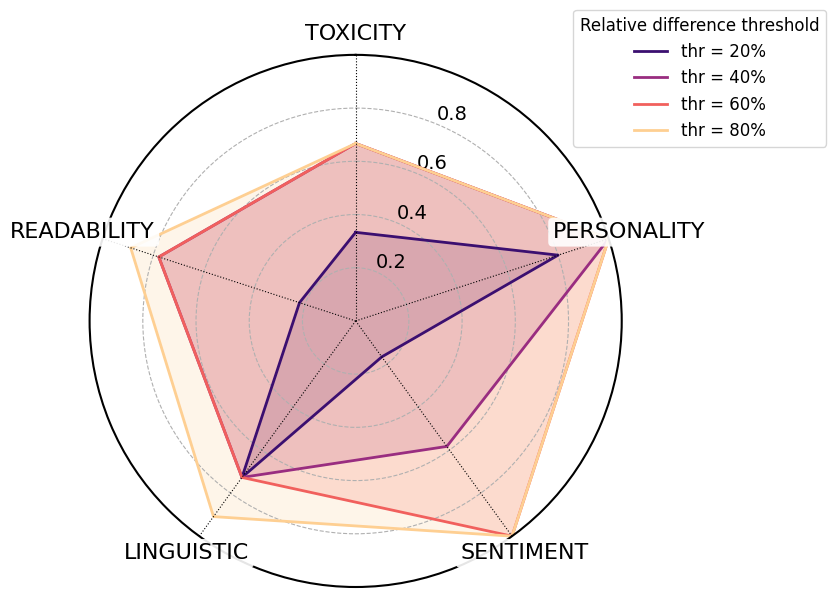

In [ ]:
#plot_goodness(valid_metrics, [0.2, 0.4, 0.6, 0.8])

## Local Validation

### Profiles Mapping
- the idea is to map real and simulated clusters based on the mean of dataset-wise standardized toxicity types
    - this is done to ensure we identify the most dominant toxicities in each cluster, regardless of absolute magnitude
    - for each dataset separately
    - and then match each real-simulated toxic profiles qualitatively and quantitatively (e.g. by exploiting heatmaps)

- once we have the matching pairs (or even non-matching -> max distance)
    - we go back to the raw transparent features to evaluate the distance between the matching pairs
    - across the several aspects


##### Clusters' composition

Real data clusters' cardinality: {2: 22310, 3: 10744, 0: 5459, 5: 3952, 1: 4631, 4: 2904}


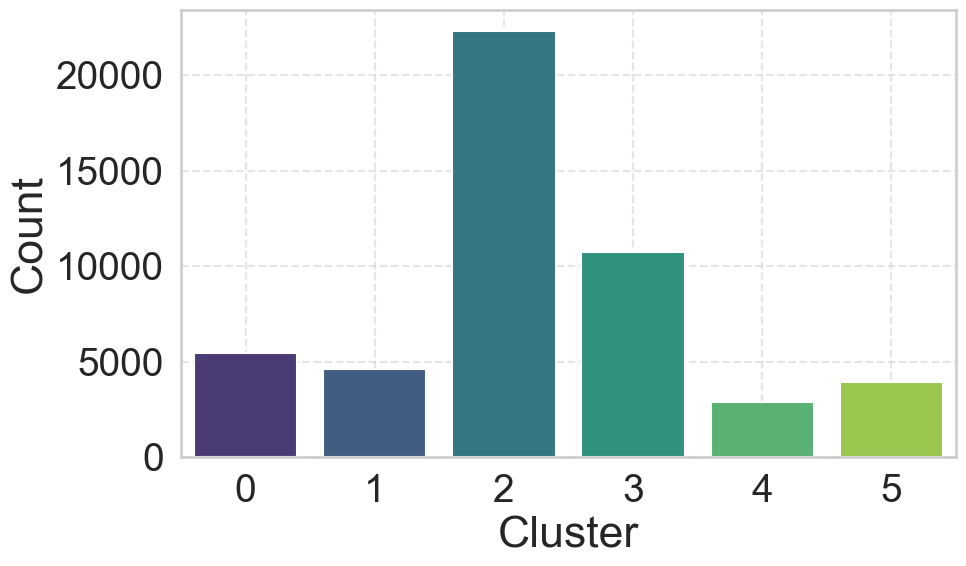

In [12]:
# real data
print(f"Real data clusters' cardinality: {dict(Counter(df_real['cluster']))}")
plot_counts(df_real, "cluster", title = "Cluster composition - Real Data")

Before mod data clusters' cardinality: {0: 749, 1: 897, 4: 359, 5: 356, 3: 528, 2: 242}


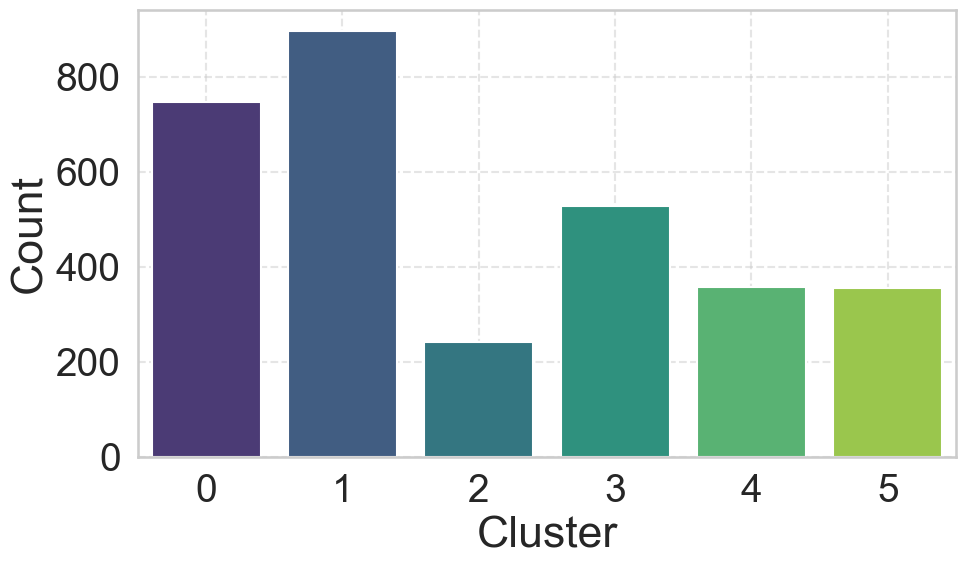

In [13]:
# simulated data
print(f"Before mod data clusters' cardinality: {dict(Counter(df_bef['cluster']))}")
plot_counts(df_bef, "cluster", title = "Cluster composition - Unmoderated Data")

##### Clusters' toxicity

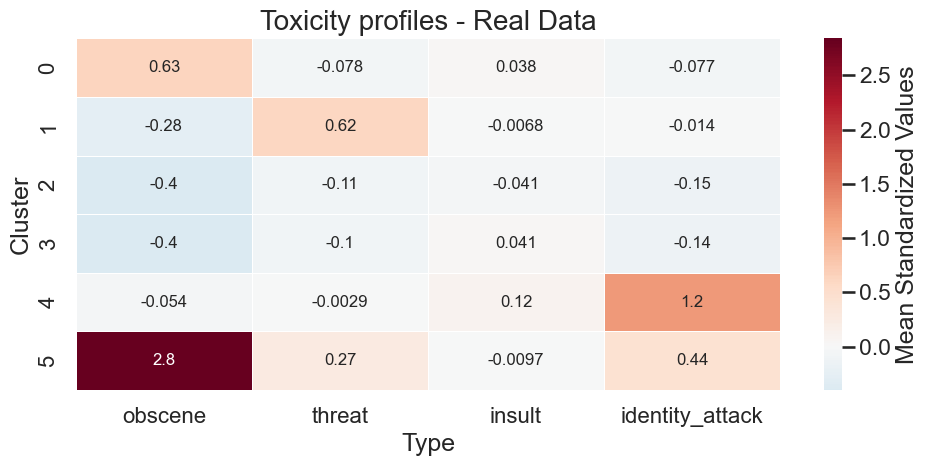

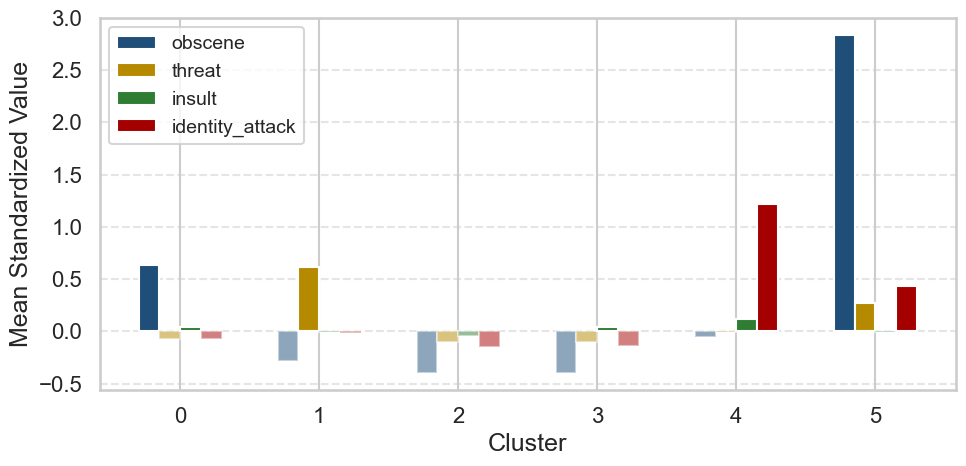

In [14]:
# mean standardized toxicity for real data
real_tox_centroids = plot_std_centroids(df_real, tox_feat, "cluster", title = "Toxicity profiles - Real Data")

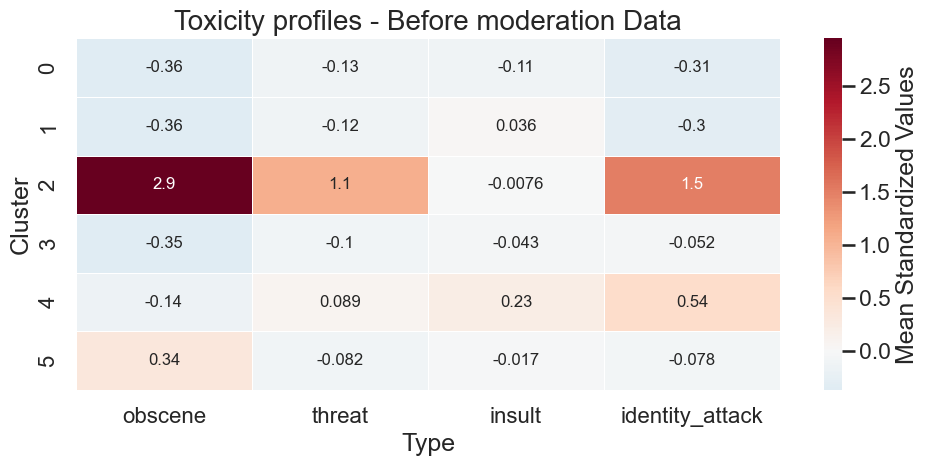

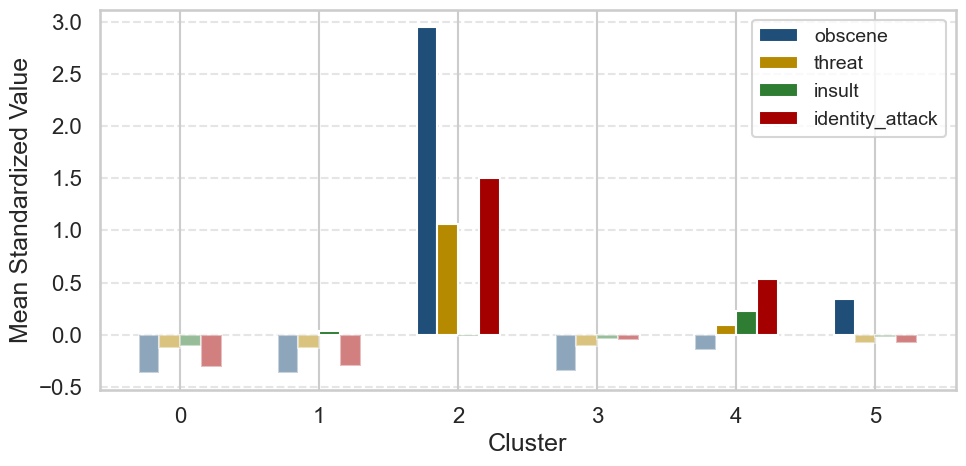

In [15]:
# mean standardized toxicity for simulated data
bef_tox_centroids = plot_std_centroids(df_bef, tox_feat, "cluster", title = "Toxicity profiles - Before moderation Data")

##### Clusters' matching and characterization
- we exploit cosine similarity to define compare cluster centroids (std toxicity mean), and we minimize the overall dissimilarity

- we then give clusters toxicity-related names to distinguish the different toxic profiles according to the heatmap scores

In [16]:
# match the clusters to minimize the overall dissimilarity (using cosine similarity matrix)
df_match, df_similarity = match_clusters(real_tox_centroids, bef_tox_centroids, "Real", "Before")

df_match

,Best Before cluster,Cosine similarity
Real cluster,,
0,5,0.983901
1,3,0.140553
2,0,0.936048
3,1,0.943655
4,4,0.924771
5,2,0.928539


Investigating the heatmaps, clusters match properly, except the least similar (Real cluster 1 and Simulated cluster 3)
- we can therefore avoid a one-to-one label mapping for these, and instead give different connotations

Overall, the found profiles can be named as follows:
- Real 0 and Sim 5 -> Vulgar
- Real 2 and Sim 0 -> Healthy
- Real 3 and Sim 1 -> Offensive
- Real 4 and Sim 4 -> Discriminatory
- Real 5 and Sim 2 -> Hostile
- Real 1 -> Aggressive
- Sim 3 -> Healthy

In [17]:
# cluster to toxic profile mappings
real_mapping = {0: "Vulgar", 2: "Healthy", 3: "Offensive", 4: "Discriminatory", 5: "Hostile", 1: "Aggressive"}
bef_mapping = {5: "Vulgar", 0: "Healthy", 1: "Offensive", 4: "Discriminatory", 2: "Hostile", 3: "Healthy"}

In [18]:
# annotating comments with profile name based on the clusters' (dataset-wise) dominant toxicity
df_real = annotate_profile(df_real, real_mapping, "cluster", profile_name = "tox_profile")
df_bef = annotate_profile(df_bef, bef_mapping, "cluster", profile_name = "tox_profile")

In [19]:
df_real.head(2)

,author,comment_id,std_body,gender,openness,conscientiousness,extraversion,agreeableness,neuroticism,num_punct,num_sents,num_words_upp,num_emoji,num_emoji_pos,num_emoji_neg,emoji_unique,emoji_list,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,polarity,subjectivity,valence,arousal,dominance,flesch,flesch_kincaid,fog,smog,ari,coleman_liau,dale_chall,linsear,difficult_words,num_words,num_words_unique,num_words_adj,num_words_noun,num_words_verb,num_words_lex,num_stopw,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,is_toxic,go,holy fuck,homosexual,say,know,well,bunch,shit,man,racist,would,stupid,also,guy,liberal,make,country,religion,real,crap,right,keep,people,dick,need,asshole,nothing,woman,bitch,one,give,fuck shit,die,black,immigrant,kill,dude,fucking,nigga,suck,take,good,try,idiot,call,insult insult,life,think,society,fuckin,someone,want,stop,see,f cking,way,time,damn,white,fuck,government,get,u,gay,even,death,thing,control,money,muslim,family,hope,really,like,is_real,cluster,sent_balance,sent_emoji_balance,punct_ratio,upper_ratio,emoji_ratio,adj_ratio,noun_ratio,verb_ratio,lex_ratio,stopw_ratio,words_sent_ratio,ttr,complex_ratio,tox_profile
0,quiteafewfireflies,306083,oh many flaw haha mostly affect anyone else,f,very high,very low,medium,medium,very high,5,2,0,0,0,0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425,0.45,0.052826,0.041652,0.050913,87.72,3.3,3.60,0.0,1.9,2.52,6.71,4.0,2.0,18,17,2,4,3,9,10,0.004256,0.000098,0.000337,0.000113,0.0,0.000168,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.0,0,0.277778,0.0,0.0,0.111111,0.222222,0.166667,0.5,0.555556,9.0,1.000000,0.111111,Healthy
1,Djzongreethesecond,134780,go vote rand paul guess not probably trump guess,t,medium,very low,medium,very low,very high,1,1,0,0,0,0,,,0.0,0.1,0.0,0.1,0.3,0.1,0.1,0.1,0.0,0.1,0.000,0.00,0.120190,0.085048,0.094619,86.03,6.0,9.71,0.0,4.7,2.85,7.90,10.5,1.0,20,16,1,8,3,12,11,0.000937,0.000104,0.000168,0.000119,0.0,0.000159,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.0,0,0.050000,0.0,0.0,0.050000,0.400000,0.150000,0.6,0.550000,20.0,0.888889,0.050000,Healthy


##### Storing the annotated datasets

In [20]:
# for real vs simulated
df_real.to_csv("../data_real_before/PANDORA_test_profiles.csv", index = False, encoding = "utf-8")
df_bef.to_csv("../data_real_before/SIMULATOR_exante_bef_profiles.csv", index = False, encoding = "utf-8")
# for before vs after moderation
df_bef.to_csv("../data_before_after/SIMULATOR_exante_bef_profiles.csv", index = False, encoding = "utf-8")

### Validation metrics

##### Healthy profile

In [21]:
equal_heal, diff_heal, valid_metrics_heal = validation_metrics(df_real, df_bef, profile = "Healthy", tox_cols = tox_feat, pers_cols = ocean_feat, 
                                                               sent_cols = sent_feat, ling_cols = ling_feat, read_cols = read_feat,
                                                               pval_thr = 0.01, sort_by = "rel_mean_diff", top = None, name_1 = "Real", name_2 = "Unmoderated")

## Validating Real against Unmoderated data ##
LOCAL VALIDATION: Healthy profile
----------------------

Size of Real data: 22310
Size of Unmoderated data: 1277


------- TOXIC dimension -------
Non-significally different features (p-value < 0.01):
['insult']
Significally different features (p-value < 0.01):
['obscene', 'threat', 'identity_attack']

Metrics for all significally different features:
** identity_attack **
	rel_mean_diff: -40.80278
	rel_std_diff: -28.17135
	rel_p10_diff: -0.04274
	rel_p25_diff: -0.07216
	rel_p50_diff: -0.38215
	rel_p75_diff: -12.67854
	rel_p90_diff: -70.17164
	KS: 0.38944
** threat **
	rel_mean_diff: -1.7
	rel_std_diff: -2.34526
	rel_p10_diff: -0.13597
	rel_p25_diff: -0.13351
	rel_p50_diff: -0.17607
	rel_p75_diff: -1.50458
	rel_p90_diff: -4.01281
	KS: 0.39438
** obscene **
	rel_mean_diff: -0.30776
	rel_std_diff: 0.34448
	rel_p10_diff: 0.0238
	rel_p25_diff: 0.00958
	rel_p50_diff: -0.05833
	rel_p75_diff: -1.87178
	rel_p90_diff: -3.03851
	KS: 0.23537


------

In [ ]:
#compute_goodness_scores(valid_metrics_heal, thr = 0.2)

{'TOXICITY': 0.0,
 'PERSONALITY': 1.0,
 'SENTIMENT': 0.167,
 'LINGUISTIC': 0.636,
 'READABILITY': 0.111}

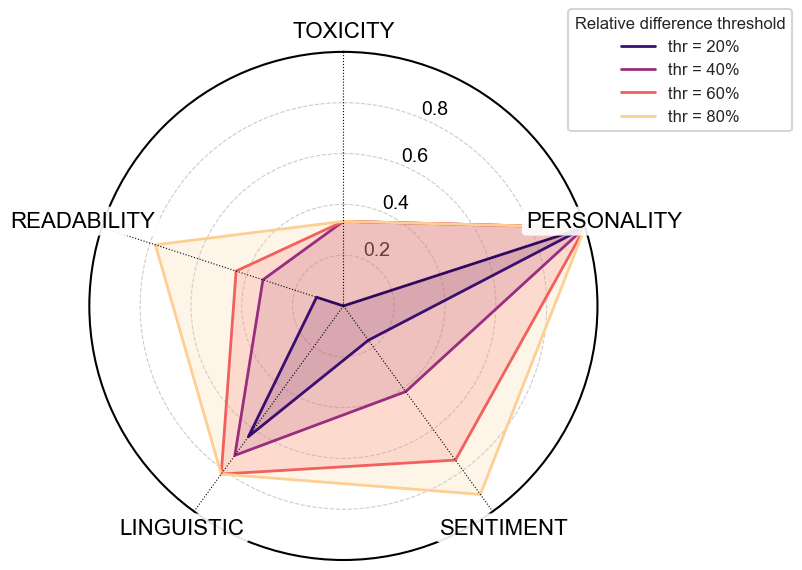

In [ ]:
#plot_goodness(valid_metrics_heal, [0.2, 0.4, 0.6, 0.8])

##### Vulgar profile

In [24]:
equal_vulg, diff_vulg, valid_metrics_vulg = validation_metrics(df_real, df_bef, profile = "Vulgar", tox_cols = tox_feat, pers_cols = ocean_feat, 
                                                               sent_cols = sent_feat, ling_cols = ling_feat, read_cols = read_feat,
                                                               pval_thr = 0.01, sort_by = "rel_mean_diff", top = None, name_1 = "Real", name_2 = "Simulated")

## Validating Real against Simulated data ##
LOCAL VALIDATION: Vulgar profile
----------------------

Size of Real data: 5459
Size of Simulated data: 356


------- TOXIC dimension -------
Non-significally different features (p-value < 0.01):
['insult']
Significally different features (p-value < 0.01):
['obscene', 'threat', 'identity_attack']

Metrics for all significally different features:
** identity_attack **
	rel_mean_diff: -6.34763
	rel_std_diff: -7.95278
	rel_p10_diff: -1.00583
	rel_p25_diff: -0.96649
	rel_p50_diff: -1.77813
	rel_p75_diff: -3.59613
	rel_p90_diff: -5.80811
	KS: 0.34009
** obscene **
	rel_mean_diff: 0.39439
	rel_std_diff: 0.17745
	rel_p10_diff: -0.08484
	rel_p25_diff: 0.72409
	rel_p50_diff: 0.78091
	rel_p75_diff: 0.46125
	rel_p90_diff: 0.21157
	KS: 0.19189
** threat **
	rel_mean_diff: -0.1346
	rel_std_diff: 0.49827
	rel_p10_diff: -0.38965
	rel_p25_diff: -0.07631
	rel_p50_diff: -0.02845
	rel_p75_diff: -0.23096
	rel_p90_diff: -0.49615
	KS: 0.08849


------- PERSONALI

In [ ]:
#compute_goodness_scores(valid_metrics_vulg, thr = 0.2)

{'TOXICITY': 0.333,
 'PERSONALITY': 0.6,
 'SENTIMENT': 0.667,
 'LINGUISTIC': 0.818,
 'READABILITY': 0.778}

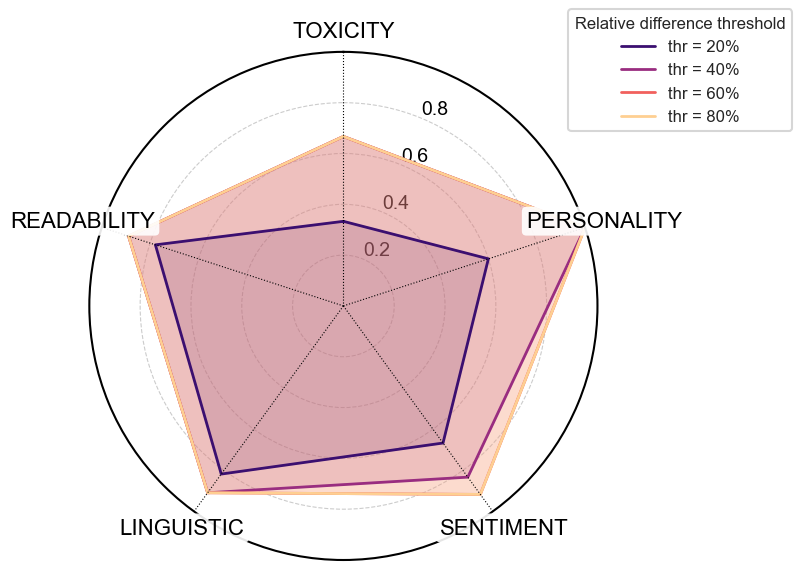

In [ ]:
#plot_goodness(valid_metrics_vulg, [0.2, 0.4, 0.6, 0.8])

##### Offensive profile

In [27]:
equal_off, diff_off, valid_metrics_off = validation_metrics(df_real, df_bef, profile = "Offensive", tox_cols = tox_feat, pers_cols = ocean_feat, 
                                                               sent_cols = sent_feat, ling_cols = ling_feat, read_cols = read_feat,
                                                               pval_thr = 0.01, sort_by = "rel_mean_diff", top = None, name_1 = "Real", name_2 = "Simulated")

## Validating Real against Simulated data ##
LOCAL VALIDATION: Offensive profile
----------------------

Size of Real data: 10744
Size of Simulated data: 897


------- TOXIC dimension -------
Non-significally different features (p-value < 0.01):
['insult']
Significally different features (p-value < 0.01):
['obscene', 'threat', 'identity_attack']

Metrics for all significally different features:
** identity_attack **
	rel_mean_diff: -0.81848
	rel_std_diff: -0.19398
	rel_p10_diff: -0.12339
	rel_p25_diff: -0.24999
	rel_p50_diff: -0.66085
	rel_p75_diff: -1.3146
	rel_p90_diff: -1.53488
	KS: 0.46047
** obscene **
	rel_mean_diff: 0.71701
	rel_std_diff: 0.79268
	rel_p10_diff: 0.07121
	rel_p25_diff: 0.06743
	rel_p50_diff: 0.01887
	rel_p75_diff: 0.04666
	rel_p90_diff: 0.48652
	KS: 0.23966
** threat **
	rel_mean_diff: 0.12582
	rel_std_diff: 0.88275
	rel_p10_diff: -0.08
	rel_p25_diff: -0.08785
	rel_p50_diff: -0.13462
	rel_p75_diff: -0.43204
	rel_p90_diff: -0.2563
	KS: 0.30682


------- PERSONALITY

In [ ]:
#compute_goodness_scores(valid_metrics_off, thr = 0.2)

{'TOXICITY': 0.333,
 'PERSONALITY': 1.0,
 'SENTIMENT': 0.667,
 'LINGUISTIC': 0.727,
 'READABILITY': 0.667}

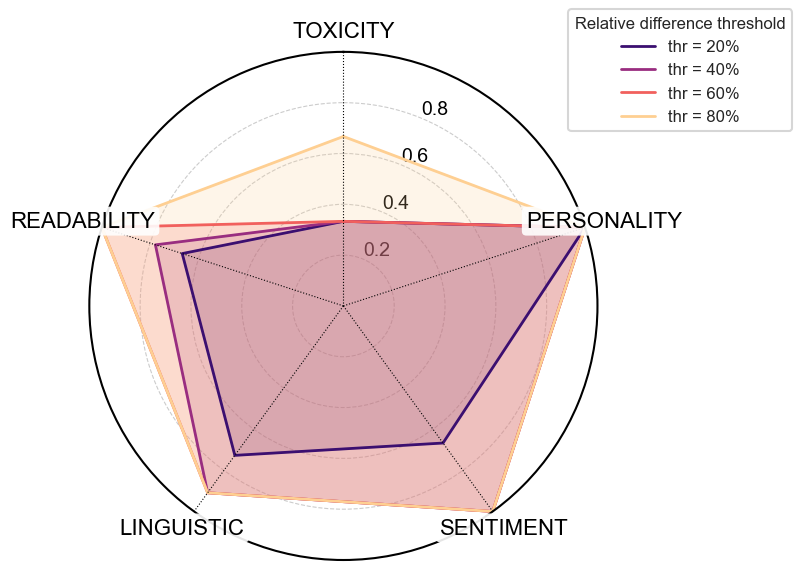

In [ ]:
#plot_goodness(valid_metrics_off, [0.2, 0.4, 0.6, 0.8])

##### Discriminatory profile

In [30]:
equal_disc, diff_disc, valid_metrics_disc = validation_metrics(df_real, df_bef, profile = "Discriminatory", tox_cols = tox_feat, pers_cols = ocean_feat, 
                                                               sent_cols = sent_feat, ling_cols = ling_feat, read_cols = read_feat,
                                                               pval_thr = 0.01, sort_by = "rel_mean_diff", top = None, name_1 = "Real", name_2 = "Simulated")

## Validating Real against Simulated data ##
LOCAL VALIDATION: Discriminatory profile
----------------------

Size of Real data: 2904
Size of Simulated data: 359


------- TOXIC dimension -------
Non-significally different features (p-value < 0.01):
['insult']
Significally different features (p-value < 0.01):
['obscene', 'threat', 'identity_attack']

Metrics for all significally different features:
** threat **
	rel_mean_diff: -0.5143
	rel_std_diff: 0.39256
	rel_p10_diff: -2.03687
	rel_p25_diff: -2.53111
	rel_p50_diff: -1.30973
	rel_p75_diff: -0.90441
	rel_p90_diff: -1.15798
	KS: 0.28495
** identity_attack **
	rel_mean_diff: -0.46342
	rel_std_diff: -0.33142
	rel_p10_diff: -2.98802
	rel_p25_diff: -3.99295
	rel_p50_diff: -1.35065
	rel_p75_diff: -0.56038
	rel_p90_diff: -0.52938
	KS: 0.1862
** obscene **
	rel_mean_diff: 0.44353
	rel_std_diff: 0.32105
	rel_p10_diff: -1.05077
	rel_p25_diff: -0.38736
	rel_p50_diff: 0.31901
	rel_p75_diff: 0.6072
	rel_p90_diff: 0.63924
	KS: 0.09666


------- PE

In [ ]:
#compute_goodness_scores(valid_metrics_disc, thr = 0.2)

{'TOXICITY': 0.0,
 'PERSONALITY': 0.6,
 'SENTIMENT': 0.0,
 'LINGUISTIC': 0.7,
 'READABILITY': 0.667}

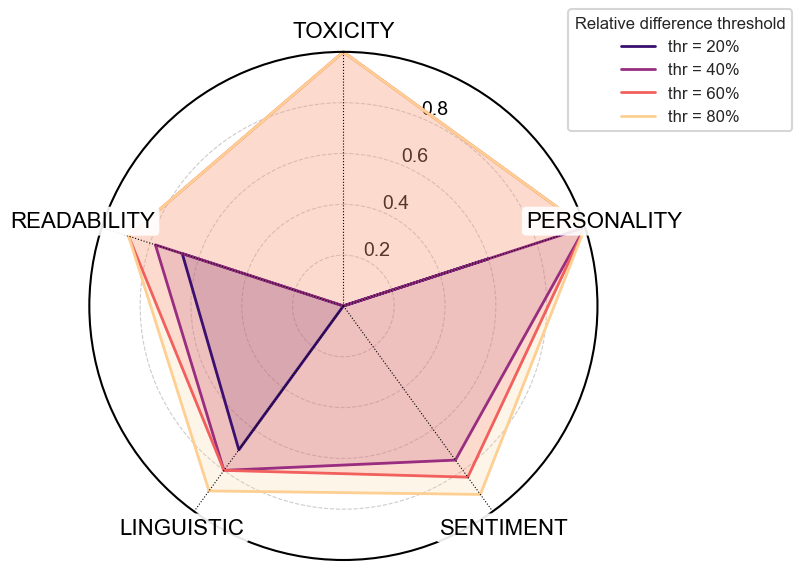

In [ ]:
#plot_goodness(valid_metrics_disc, [0.2, 0.4, 0.6, 0.8])

##### Hostile profile

In [33]:
equal_host, diff_host, valid_metrics_host = validation_metrics(df_real, df_bef, profile = "Hostile", tox_cols = tox_feat, pers_cols = ocean_feat, 
                                                               sent_cols = sent_feat, ling_cols = ling_feat, read_cols = read_feat,
                                                               pval_thr = 0.01, sort_by = "rel_mean_diff", top = None, name_1 = "Real", name_2 = "Simulated")

## Validating Real against Simulated data ##
LOCAL VALIDATION: Hostile profile
----------------------

Size of Real data: 3952
Size of Simulated data: 242


------- TOXIC dimension -------
Non-significally different features (p-value < 0.01):
['insult']
Significally different features (p-value < 0.01):
['obscene', 'threat', 'identity_attack']

Metrics for all significally different features:
** identity_attack **
	rel_mean_diff: -6.32518
	rel_std_diff: -1.38617
	rel_p10_diff: -2.75078
	rel_p25_diff: -6.53712
	rel_p50_diff: -20.44242
	rel_p75_diff: -29.19656
	rel_p90_diff: -17.0832
	KS: 0.62199
** threat **
	rel_mean_diff: -1.32252
	rel_std_diff: -0.4133
	rel_p10_diff: -0.22229
	rel_p25_diff: -0.45042
	rel_p50_diff: -1.68158
	rel_p75_diff: -2.97772
	rel_p90_diff: -5.64786
	KS: 0.37363
** obscene **
	rel_mean_diff: 0.09854
	rel_std_diff: -0.31053
	rel_p10_diff: 0.30063
	rel_p25_diff: 0.14431
	rel_p50_diff: 0.08006
	rel_p75_diff: 0.02016
	rel_p90_diff: -0.00178
	KS: 0.22536


------- PERS

In [ ]:
#compute_goodness_scores(valid_metrics_host, thr = 0.2)

{'TOXICITY': 0.333,
 'PERSONALITY': 0.2,
 'SENTIMENT': 0.583,
 'LINGUISTIC': 0.8,
 'READABILITY': 0.556}

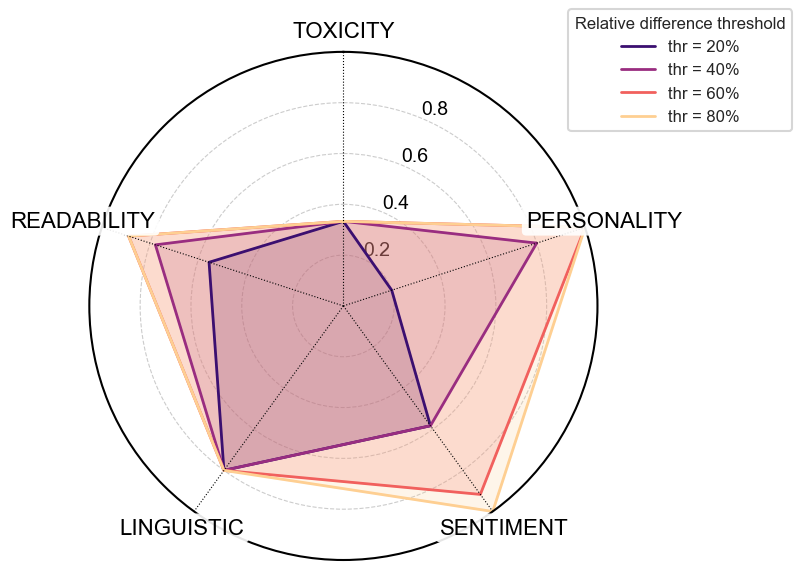

In [ ]:
#plot_goodness(valid_metrics_host, [0.2, 0.4, 0.6, 0.8])

##### Aggressive profile
- we have no match for such cluster in the simulated data
    - so we give the maximum distance score
    - we can say something about this